In [23]:
# @title LIBS
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Subset, random_split
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, classification_report

import pdb
import random
import itertools

In [24]:
# @title Configuration Parameters
class Config:
    # MNIST DATASET
    IMG_NUMELEMS = 784
    IMG_SIZE = (1,28,28)
    TRAIN_SIZE = 60000
    TEST_SIZE = 10000

    # Training parameters
    BATCH_SIZE = 64
    NUM_EPOCHS = 100
    LEARNING_RATE = 2e-2

    # Loss parameters
    lambda_l1 = 0
    kl_weight = 0
    lambda_contractive = 0
    NOISE_STD = 2e-2

    # Model parameters (Autoencoder)
    LATENT_DIM = 64
    HIDDEN_DIMS = [128]  # Encoder/Decoder hidden dimensions
    PATH = 'Best_Autoencoder.pt'

    # Early stopping parameters
    PATIENCE = 5

    # K-fold parameters
    N_SPLITS = 5

    # Other parameters
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    @classmethod
    def update(cls, hp_dict):
        for key, value in hp_dict.items():
            setattr(cls, key, value)

    @staticmethod
    def print_config():
        print(f"Running on device: {Config.DEVICE}")
        print(f"Learning rate: {Config.LEARNING_RATE}")
        print(f"Batch size: {Config.BATCH_SIZE}")
        print(f"Hidden dimensions : {Config.HIDDEN_DIMS}")
        print(f"Latent dimensions : {Config.LATENT_DIM}")
        print(f"Additive Noise (STD) : {Config.NOISE_STD}")
        print(f"Sparsity strength : {Config.lambda_l1}")
        print(f"Contractivity strength : {Config.lambda_contractive}")
        print(f"KL div strength : {Config.kl_weight}")

In [25]:
# @title Load Dataset
def load_dataloaders():
    transform = transforms.Compose([
    transforms.ToTensor()
])
    # Load full MNIST datasets
    train_full = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_full = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

    # Random subset indices (non-balanced)
    train_indices = np.random.choice(len(train_full), Config.TRAIN_SIZE, replace=False)
    test_indices = np.random.choice(len(test_full), Config.TEST_SIZE, replace=False)

    # Create subsets
    train_dataset = Subset(train_full, train_indices)
    test_dataset = Subset(test_full, test_indices)

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size= Config.BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size= Config.BATCH_SIZE, shuffle=False)

    return train_loader, test_loader


In [26]:
# @title Autoencoder Class
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(Autoencoder, self).__init__()

        self.latent_dim = latent_dim
        self.ae_type = 'ae'

        # Encoder
        encoder_layers = create_layers_list(nn.Flatten, nn.Linear, (nn.Linear, nn.BatchNorm1d, nn.ReLU), (input_dim, hidden_dims, latent_dim))
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        decoder_layers = create_layers_list(None, nn.Linear, (nn.Linear, nn.BatchNorm1d, nn.ReLU), (latent_dim, reversed(hidden_dims), input_dim))
        decoder_layers.append(nn.Sigmoid())
        decoder_layers.append(nn.Unflatten(1, Config.IMG_SIZE))
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        z = self.encode(x)
        x_reconstructed = self.decode(z)
        return x_reconstructed, z

    def get_latent_features(self, x):
        return self.encoder(x)

    def calculate_contraction_penalty(self, x):
        x.requires_grad_(True)
        z = self.encoder(x)

        # Calculate Jacobian matrix for each latent dimension
        jacobian = []
        for i in range(self.latent_dim):
            grad_outputs = torch.zeros_like(z)
            grad_outputs[:, i] = 1
            gradients = torch.autograd.grad(
                outputs=z,
                inputs=x,
                grad_outputs=grad_outputs,
                create_graph=True,
                retain_graph=True
            )[0]
            jacobian.append(gradients.view(gradients.size(0), -1))

        # Stack to create the full Jacobian tensor
        jacobian = torch.stack(jacobian, dim=1)

        # Calculate Frobenius norm squared for each example
        frob_norm_squared = torch.sum(jacobian**2, dim=(1, 2)) / self.latent_dim

        return torch.mean(frob_norm_squared)

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        self.ae_type = 'vae'

        # Encoder layers (shared)
        encoder_shared = create_layers_list(nn.Flatten, None, (nn.Linear, nn.BatchNorm1d, nn.Sigmoid), (input_dim, hidden_dims, latent_dim))
        self.encoder_shared = nn.Sequential(*encoder_shared)

        # Mean and log variance projections
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)

        # Decoder
        decoder_layers = create_layers_list(None, nn.Linear, (nn.Linear, nn.BatchNorm1d, nn.Sigmoid), (latent_dim, reversed(hidden_dims), input_dim))
        decoder_layers.append(nn.Sigmoid())
        decoder_layers.append(nn.Unflatten(1, Config.IMG_SIZE))
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        x = self.encoder_shared(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, (mu, logvar)

    def get_latent_features(self, x):
        mu, _ = self.encode(x)
        return mu


def create_layers_list(start_layer, end_layer, layer_block, dims):
    input_dim, hidden_dims, latent_dim = dims
    layers = []
    if start_layer != None : layers.append(start_layer())
    prev_dim = input_dim
    for hidden_dim in hidden_dims:
        layers.append(layer_block[0](prev_dim, hidden_dim))
        layers.append(layer_block[1](hidden_dim))
        layers.append(layer_block[2]())
        prev_dim = hidden_dim
    if end_layer != None : layers.append(end_layer(prev_dim, latent_dim))
    return layers

In [27]:
# @title Loss functions
def loss_fn(model, x_reconstructed, x, z):
    if model.ae_type == 'ae' :
        l = autoencoder_loss(model, x_reconstructed, x, z)
    elif model.ae_type == 'vae' :
        l = vae_loss_function(model, x_reconstructed, x, z)
    else:
        raise TypeError()
    return l

# Loss function for DAE/CAE
def autoencoder_loss(model, x_reconstructed, x, z):
    reconstruction_loss = F.binary_cross_entropy(x_reconstructed, (x >= 0.5).float())
    sparsity_loss = torch.mean(torch.abs(z))
    contractive_loss = torch.tensor([0.0], device= Config.DEVICE)
    if Config.lambda_contractive != 0 and model.training :
        contractive_loss = model.calculate_contraction_penalty(x)
    total_loss = reconstruction_loss + Config.lambda_l1 * sparsity_loss + Config.lambda_contractive * contractive_loss
    return total_loss, reconstruction_loss, contractive_loss

# Loss function for VAE
def vae_loss_function(model, recon_x, x, z):
    mu, logvar = z
    logvar = torch.clamp(logvar, min=-20, max=20)  # prevent exploding KL

    recon_loss = F.binary_cross_entropy(recon_x, (x >= 0.5).float(), reduction='mean')
    kl_div = -0.5 * torch.mean(torch.mean(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    total_loss = recon_loss + Config.kl_weight * kl_div

    return total_loss, recon_loss, kl_div

In [28]:
# @title Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [29]:
# @title Train Autoencoder
def train_autoencoder(model, train_loader, val_loader, config):
    print(f"Training autoencoder {model.ae_type} ...")
    optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    early_stopping = EarlyStopping(patience=config.PATIENCE, verbose=False, path= config.PATH)

    train_losses, val_losses = [], []

    for epoch in range(config.NUM_EPOCHS):
        train_loss, recon_loss, smooth_loss = train_one_epoch(model, optimizer, train_loader, config)
        val_loss, recon_val_loss, smooth_val_loss = validate_one_epoch(model, val_loader, config)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{config.NUM_EPOCHS}:')
            print(f'Train Loss= {train_loss:.4f} (Recon_Loss= {recon_loss:.4f}, Smooth_Loss= {smooth_loss:.4f})')
            print(f'Val   Loss= {val_loss:.4f} (Recon_Loss= {recon_val_loss:.4f}, Smooth_Loss= {smooth_val_loss:.4f})')

        # Early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Load best model after all epochs
    model.load_state_dict(torch.load(config.PATH))

    return model, train_losses, val_losses


def train_one_epoch(model, optimizer, train_loader, config):
    model.train()
    num_batches = len(train_loader)
    train_loss = 0
    recon_loss_total, smooth_loss_total = 0, 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(config.DEVICE), batch_y.to(config.DEVICE)

        batch_x_noisy = batch_x + torch.randn_like(batch_x) * config.NOISE_STD
        batch_x_noisy = torch.clamp(batch_x_noisy, 0.0, 1.0)
        optimizer.zero_grad()

        x_reconstructed, z = model(batch_x_noisy)
        loss, recon_loss, smooth_loss = loss_fn(model, x_reconstructed, batch_x, z)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        smooth_loss_total += smooth_loss.item()

    return train_loss/num_batches , recon_loss_total/num_batches , smooth_loss_total/num_batches

def validate_one_epoch(model, val_loader, config):
    model.eval()
    num_batches = len(val_loader)
    val_loss = 0
    recon_loss_total, smooth_loss_total = 0, 0

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(config.DEVICE), batch_y.to(config.DEVICE)

            x_reconstructed, z = model(batch_x)
            loss, recon_loss, smooth_loss = loss_fn(model, x_reconstructed, batch_x, z)
            try:
                val_loss += loss.item()
                recon_loss_total += recon_loss.item()
                smooth_loss_total += smooth_loss.item()
            except RuntimeError as e:
                pdb.set_trace()

    return val_loss/num_batches , recon_loss_total/num_batches , smooth_loss_total/num_batches


def fit_AE(model, train_loader, config):
    print(f"Training autoencoder {model.ae_type} ...")
    optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
    train_losses = []

    for epoch in range(config.NUM_EPOCHS):
        train_loss, recon_loss, smooth_loss = train_one_epoch(model, optimizer, train_loader, config)
        train_losses.append(train_loss)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{config.NUM_EPOCHS}:')
            print(f'Train Loss= {train_loss:.4f} (Recon_Loss= {recon_loss:.4f}, Smooth_Loss= {smooth_loss:.4f})')

    return model, train_losses

In [30]:
# @title HP Tuning
def hyperparameter_tuning(model_class, hp_grid, dataset, config):
    labels = np.array([y for _, y in dataset])
    skf = StratifiedKFold(n_splits= config.N_SPLITS, shuffle=True)

    hp_configs = make_hp_configs(hp_grid)
    results = []

    for hp_config  in hp_configs:
        print(f"\nTesting: {hp_config}")
        fold_losses = []
        Config.update(hp_config)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
            print(f" Fold {fold_idx+1}/{config.N_SPLITS}")

            train_subset = Subset(dataset, train_idx)
            val_subset = Subset(dataset, val_idx)

            train_loader = DataLoader(train_subset, batch_size= config.BATCH_SIZE, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size= config.BATCH_SIZE)

            model = model_class(config.IMG_NUMELEMS, config.HIDDEN_DIMS, config.LATENT_DIM).to(Config.DEVICE)
            _, _, val_losses = train_autoencoder(model, train_loader, val_loader, config)
            val_loss_best = val_losses[-config.PATIENCE - 1]
            fold_losses.append(val_loss_best)

        avg_loss = np.mean(fold_losses)
        print(f"Avgerage loss on validation set: {avg_loss:.4f}")

        results.append({
            **hp_config,
            'avg_val_loss': avg_loss,
        })

    best_result = min(results, key=lambda x: x['avg_val_loss'])
    print(f"\nBest Hyperparameters: {best_result}")

    return best_result

def make_hp_configs(hp_grid):
    hp_names = list(hp_grid.keys())
    hp_vals = list(itertools.product(*hp_grid.values()))
    hp_configs = [dict(zip(hp_names, hp)) for hp in hp_vals]

    if not ('BATCH_SIZE' in hp_grid and 'LEARNING_RATE' in hp_grid) :
        return hp_configs

    for hp_config in hp_configs:
        base_bs = hp_grid['BATCH_SIZE'][0]
        curr_bs = hp_config['BATCH_SIZE']
        hp_config['LEARNING_RATE'] *= curr_bs / base_bs

    return hp_configs


In [31]:
# @title Eval Autoencoder
def evaluate_AE(ae, data_loader):
    ae.eval()

    all_latents, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(Config.DEVICE), labels.to(Config.DEVICE)

            z = ae.get_latent_features(inputs)
            all_latents.extend(z.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_latents, all_labels = np.array(all_latents), np.array(all_labels)

    return all_latents, all_labels

In [32]:
# @title Dim Reduction Function
from sklearn.manifold import TSNE

def apply_reduction_dim(X, perplexity = 30, max_iter = 1000, n_components=2):
    reducer = TSNE(n_components = n_components, perplexity = perplexity, max_iter = max_iter)
    return reducer.fit_transform(X)

In [33]:
# @title Visualize Latent Space
def visualize_latent_space(autoencoder, test_loader, config):

    all_features, all_labels = evaluate_AE(autoencoder, test_loader)

    # Reduce dimensionality for visualization if needed
    if all_features.shape[1] > 2:
        all_features = apply_reduction_dim(all_features)
        print("Applied TSNE to reduce dimensions to 2 for visualization")

    # Plot reduced features
    plt.figure()
    scatter = plt.scatter(all_features[:, 0], all_features[:, 1], c=all_labels, cmap='tab10', alpha=1)

    plt.title('Latent Space Visualization')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.colorbar(scatter)
    plt.show()

In [34]:
# @title Visualize Reconstructions

def visualize_reconstructions(model, data_loader, num_examples=8):
    """Visualize original and reconstructed images side by side"""
    model.eval()
    with torch.no_grad():
        # Get a batch of data
        data, _ = next(iter(data_loader))
        data = data[:num_examples].to(Config.DEVICE)

        # Get reconstructions
        recon_data, *_ = model(data)

        # Plot original vs reconstructed
        plt.figure(figsize=(10, 4))
        for i in range(num_examples):
            # Original
            plt.subplot(2, num_examples, i + 1)
            plt.imshow(data[i].cpu().reshape(28,28).numpy(), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Original')

            # Reconstructed
            plt.subplot(2, num_examples, i + 1 + num_examples)
            plt.imshow(recon_data[i].cpu().reshape(28,28).numpy(), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Reconstructed')

        plt.tight_layout()
        plt.show()

In [35]:
# @title Interpolate In Latent Space

# Interpolate between two points in latent space
def interpolate_latent_space(model, img1, img2, num_steps):
    """Create interpolations between two images in latent space"""
    model.eval()
    with torch.no_grad():
        # Get latent representation of both images
        z1 = model.get_latent_features(img1.unsqueeze(0).to(Config.DEVICE))
        z2 = model.get_latent_features(img2.unsqueeze(0).to(Config.DEVICE))

        # Create interpolation steps
        alphas = torch.linspace(0, 1, num_steps).to(Config.DEVICE)
        z_interps = []

        for alpha in alphas:
            # Linear interpolation in latent space
            z_interp = (1 - alpha) * z1 + alpha * z2
            z_interps.append(z_interp)

        # Stack all interpolated points and decode
        z_interps = torch.cat(z_interps, dim=0)
        interps = model.decode(z_interps)

    return interps

# Generate new samples from the autoencoder
def generate_samples(model, num_samples):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim).to(Config.DEVICE)
        samples = model.decode(z)
    return samples

In [36]:
# @title Plot Batch of Images
def plot_imags(imgs, title):
    num_imgs = imgs.size(0)
    plt.figure()
    for i in range(num_imgs):
        plt.subplot(1, num_imgs, i + 1)
        plt.imshow(imgs[i].cpu().reshape(28,28).numpy(), cmap='gray') #
        plt.axis('off')
        if i == 0: plt.title(title)

In [37]:
# @title Linear Separability Metric
def lin_sep_metrics(X, y): # np arrs
    model = LogisticRegression(penalty= None, solver='lbfgs', max_iter= 5000)
    model.fit(X, y)
    y_pred = model.predict(X)
    print(f"LinSepMetric (accuracy): {100 * accuracy_score(y, y_pred):.1f}%", )
    return model

In [38]:
# @title SVM classifier
def SVM_clf(features, test_features, labels, test_labels):
    clf = svm.SVC()

    #grid_hps = {'kernel':['linear'], 'C':[1, 10, 100, 1000]}
    grid_hps = {'kernel': ['poly'], 'C': [1, 10, 100, 1000], 'degree': [2, 3, 4, 5], 'coef0': [-1, 0, 1]}

    grid = GridSearchCV(clf, grid_hps, cv= 5, scoring= 'accuracy', n_jobs= -1)
    grid.fit(features, labels)

    print(f'Best hps  = {grid.best_params_}')
    print(f'Best score on train set = {100 * grid.best_score_:.1f}%')

    best_clf = grid.best_estimator_
    acc = accuracy_score(test_labels, best_clf.predict(test_features))
    print(f'Accuracy on test set is {100 * acc:.1f}%')
    return best_clf

In [39]:
# @title KNN classifier
def KNN_clf(train_features, test_features, train_labels, test_labels, k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_features, train_labels)

    accuracy = knn.score(test_features, test_labels)
    print(f"Test accuracy: {100 * accuracy:.1f}%")
    return knn

In [40]:
# @title RNG Seed Set

def set_seed(seed=42, deterministic=False):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


# **Denoising AE**

We aim to model the dataset complexity by first building a Denoising Autoencoder (DAE) that explicitly learns the data manifold. This type of autoencoder is very important and straightforward to implement: before the forward pass, we add noise to the input batch, then compute the loss between the reconstructed output (from the noisy input) and the original clean batch.

The hyperparameters of this model are learning rate (lr), batch size (bs), number of epochs, noise standard deviation (std), network depth, and number of neurons per layer. We tune them using K-fold cross-validation: splitting the training set into K equal subsets, training the model K times with the same hyperparameters, each time using a different subset for validation and the rest for training. This yields K validation losses, which we average to get the metric—validation loss—that indicates how well the model generalizes with those hyperparameters (lower metric = better generalization → better hyperparameter combination).

Since this is computationally expensive, we do not explore all hyperparameter combinations at once. Instead, we tune them in groups. While generally suboptimal, this is acceptable here because prior literature guides how hyperparameters influence each other.

The first group is optimizer parameters: lr, bs, and number of epochs. We test typical batch sizes (16, 32, 64, 128) and learning rates (1e-3, 1e-2, 1e-1) with a fixed 100 epochs. Early stopping will halt training when appropriate, preventing overfitting, so we don't worry about the epoch count now.

For the initial network, we start simple: the encoder and decoder each have one layer, the latent space dimension is 8 (about 1% of MNIST image pixels), the encoder has 64 neurons (~8% of pixels), and the decoder is symmetric to the encoder. The best validation loss is achieved with bs=128 and lr=4e-3, but training is too slow. Thus, we pick bs=64 and lr=2e-2, which yields validation loss within 5% of the best but completes training much faster—a performance vs. time tradeoff.

Next, we tune the number of neurons per layer. Performance (validation loss) depends mostly on the bottleneck size (latent space dimension), less on neurons in other layers. Increasing latent dimensionality improves performance up to 32, after which gains become negligible while complexity rises substantially, so we settle on 32. The number of neurons in encoder/decoder saturates performance at around 120 neurons, with training time even slightly decreasing beyond that.

Then, we tune the standard deviation of additive input noise. Its purpose is to prevent overfitting and improve generalization by forcing the model to learn the data manifold, not just copy inputs. By adding noise, the DAE learns to map the ε-neighborhood of each training point back to that point—meaning the target function is not the identity but a more complex function, which improves reconstruction robustness to small input perturbations. This discourages memorization of training samples (which are finite) and prevents the model from acting as an identity function, thus fully utilizing the expressive power of the neural network.

It is important that noise is not too strong, as large noise leads to significant information loss and blurry reconstructions. Across tested noise levels, performance remains similar, but the slope of validation loss in the overfitting zone decreases with increased noise strength, which is valuable to note.

We then retest bs and lr combinations with the updated network to simulate training with optimal network hyperparameters and find optimizer hyperparameters that yield fast, effective training for the chosen network configuration. We obtain the same bs and lr values as before, expected since the network architecture didn't significantly change or deepen (deeper networks typically require larger bs and smaller lr). We also estimate the average number of training epochs based on cross-validation results.

Finally, we train a model using all the previously selected hyperparameters on the entire training set (without a validation set) and stop after the predetermined number of epochs, without early stopping.

We test the trained DAE via visual inspection of test set reconstructions and examine its ability to generate and interpolate in latent space. Consistent with the literature and our observations, the DAE's latent space is neither continuous nor smooth—it contains “holes” and shows poor interpolation quality.
    


In [41]:
# @title Main DAE

def main_DAE():
    # Config for DAE
    Config.NOISE_STD = 2e-2

    Config.HIDDEN_DIMS = [128]
    Config.LATENT_DIM = 32

    Config.BATCH_SIZE = 64
    Config.LEARNING_RATE = 2e-2

    Config.NUM_EPOCHS = 25

    Config.print_config()

    set_seed(42)

    # Load train set and test set
    train_loader, test_loader = load_dataloaders()
    data, _ = next(iter(test_loader))
    img1, img2 = data[:2].to(Config.DEVICE)

    # Make model
    dae = Autoencoder(Config.IMG_NUMELEMS, Config.HIDDEN_DIMS, Config.LATENT_DIM).to(Config.DEVICE)

    # HP tuning
    #hp_grid = {'BATCH_SIZE': [32,64,128,256,16], 'LEARNING_RATE':[1e-3,1e-2,1e-1]}
    #hp_grid = {'BATCH_SIZE': [64], 'LEARNING_RATE':[1e-2, 2e-2, 4e-2, 8e-2]}
    #hp_grid = {'LATENT_DIM': [8,16,24,32,40]}
    #hp_grid = {'HIDDEN_DIMS': [[64],[96],[128],[150]]}
    #hp_grid = {'NOISE_STD': [1e-3,1e-2,1e-1]}
    #hp_grid = {'NOISE_STD': [1e-2, 2e-2, 4e-2, e-2]}
    #hp_grid = {'BATCH_SIZE': [32,64,128,256,16], 'LEARNING_RATE':[1e-3,1e-2,1e-1]}
    #best_hp = hyperparameter_tuning(Autoencoder, hp_grid, train_loader.dataset, Config)

    # Train model with tuned HPs
    autoencoder, train_losses = fit_AE(dae, train_loader, Config)
    torch.save(autoencoder.state_dict(),'DAE.pt')

    # Get features
    train_features, train_labels = evaluate_AE(autoencoder, train_loader)
    test_features, test_labels = evaluate_AE(autoencoder, test_loader)

    # Visualize latent_space
    visualize_latent_space(autoencoder, train_loader, Config)
    visualize_latent_space(autoencoder, test_loader, Config)

    # Sample latent space, reconstructe and visualize them
    samples = generate_samples(autoencoder, num_samples=8)
    plot_imags(samples, title= 'Generated Images')

    # Interpolate in latent space, reconstructe and visualize them
    intrps = interpolate_latent_space(autoencoder, img1.view(28,28), img2.view(28,28), 10)
    plot_imags(intrps, title= 'Interpolated Images')

    # Visualize reconstructions of randomly selected images from test set
    visualize_reconstructions(autoencoder, test_loader, num_examples=10)

    # Plot train loss through epochs
    plt.figure()
    plt.plot(train_losses, label='Train Loss for DAE')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

# **Contractive Autoencoder**

The next function, MAIN CAE, demonstrates the process of tuning hyperparameters for the Contractive Autoencoder (CAE), training the CAE model with those hyperparameters, and testing the resulting model. The testing includes classification in the latent space using latent features from the test set with SVM and KNN classifiers, as well as reconstruction of some test images and sampling/interpolating images from the latent space.

One of the main goals of this project is to design an autoencoder for feature extraction to be used in classification tasks. According to the literature, the best candidate for this is the CAE because it provides robust latent features that are stable under small input perturbations—an extremely important property for good features. This robustness is achieved by adding an extra term to the loss function (the squared Frobenius norm of the Jacobian of the latent space).

It’s important to note that my CAE is actually a hybrid between a classic CAE and a Denoising Autoencoder (DAE) because I additionally add noise to each batch, forcing the AE to remove this noise from the input. Thus, my CAE produces robust reconstructions and latent features.

Regarding hyperparameter tuning, since we already trained a DAE, we use its hyperparameters as initial values for the CAE, except we set the contractive regularization coefficient (lambda_contractive) to an initial value. For tuning, we apply K-fold cross-validation because it yields the most robust hyperparameter performance estimates (via validation loss). The tuning process is the same as for the DAE.

First, we tune batch size (bs) and learning rate (lr) using the same logic as before: we select the combination that gives an average validation reconstruction loss within +5% of the best and has the lowest average number of epochs during K-fold validation (early stopping automatically halts training when validation loss consistently increases).

Next, we tune lambda_contractive, which controls the tradeoff between reconstruction quality and latent space smoothness.

After that, we tune the latent space dimension, which is crucial for classification by simple classifiers like SVM and KNN. Although reconstruction might be excellent, if the latent dimension is too small, features become highly nonlinear and inseparable in that space, which these classifiers cannot handle well. Therefore, it is very important that the latent space has sufficient dimension to make features as linearly separable as possible. Note that validation loss saturates around dimension 48, so increasing it further only marginally improves validation loss but does improve linear separability (measured by the LinSepMetric).

Then, we tune the number of layers and neurons per layer in the encoder. Increasing depth doesn’t significantly affect validation loss but makes features highly nonlinear and less separable because deep networks have much greater expressive power, so the latent representation lies in a highly nonlinear subspace. Also, due to training time constraints and the fact that Jacobian computations for deep encoders are very slow, we prefer to keep the encoder single-layered (the decoder is symmetric).

For the number of neurons, we choose 128 instead of 150 since training is considerably faster with fewer neurons and average validation loss is only slightly higher.

There is no need to retune the standard deviation of the input noise since its role is to make the model focus on the ε-neighborhoods around input points rather than the points themselves, thus achieving robustness. Increasing noise strength reduces the slope of the validation loss curve in the overfitting region, which is desirable, but noise should not be too strong to avoid excessive information loss and blurry reconstructions. Deep networks show a steep validation loss curve in the overfitting region.

Finally, we retune batch size and learning rate once more due to the many changes and try to estimate the best combination for training performance (loss and time). We also estimate the average number of epochs for training on the validation folds for the chosen bs and lr. With this, all hyperparameters are set, and we train the final model using them.

I would also like to highlight that the achieved accuracy on the test set is 98.2% (SVM) and 97.5% (KNN), which is excellent considering these classifiers are relatively simple and the CAE was explicitly trained only for reconstruction, not classification. **All the encoder’s expressive power is used to capture key characteristics of each class, not the key differences between classes**. The CAE is not a generative model, so interpolations and samples from latent space are poor, as expected from the literature.


In [42]:
# @title Main CAE

def main_CAE():
    # Config for CAE
    Config.HIDDEN_DIMS = [128]
    Config.LATENT_DIM = 64

    Config.BATCH_SIZE = 64
    Config.LEARNING_RATE = 2e-2

    Config.NOISE_STD = 2e-2
    Config.lambda_contractive = 2

    Config.NUM_EPOCHS = 21

    set_seed(42)

    Config.print_config()

    # Load train set and test set
    train_loader, test_loader = load_dataloaders()
    data, _ = next(iter(test_loader))
    img1, img2 = data[:2].to(Config.DEVICE)

    # Make model
    cae = Autoencoder(Config.IMG_NUMELEMS, Config.HIDDEN_DIMS, Config.LATENT_DIM).to(Config.DEVICE)

    # HP Tuning
    #hp_grid = {'BATCH_SIZE': [32,64,128,256,16], 'LEARNING_RATE':[1e-3, 1e-2, 1e-1]}
    #hp_grid = {'lambda_contractive': [10, 1, 1e-1, 1e-2]}
    #hp_grid = {'lambda_contractive': [1, 2, 4, 8]}
    #hp_grid = {'LATENT_DIM': [32,48,64,80]}
    #hp_grid = {'HIDDEN_DIMS': [[64],[96],[128],[150]]}
    #hp_grid = {'HIDDEN_DIMS': [[128,64],[128,96],[256,128], [512,128]]}
    #hp_grid = {'BATCH_SIZE': [32,64,128,256,16], 'LEARNING_RATE':[1e-3,1e-2,1e-1]}
    #best_hp = hyperparameter_tuning(Autoencoder, hp_grid, train_loader.dataset, Config)

    # Train model with tuned HPs
    autoencoder, train_losses = fit_AE(cae, train_loader, Config)
    torch.save(autoencoder.state_dict(),'CAE.pt')

    # Get features
    train_features, train_labels = evaluate_AE(autoencoder, train_loader)
    test_features, test_labels = evaluate_AE(autoencoder, test_loader)

    # Linear Separability Metrics
    lin_sep_metrics(train_features,train_labels)
    lin_sep_metrics(test_features,test_labels)

    # Classification using SVM and KNN
    SVM_clf(train_features, test_features, train_labels, test_labels)
    KNN_clf(train_features, test_features, train_labels, test_labels, k=3)

    # Visualize latent_space
    visualize_latent_space(autoencoder, train_loader, Config)
    visualize_latent_space(autoencoder, test_loader, Config)

    # Sample latent space, reconstructe and visualize them
    samples = generate_samples(autoencoder, num_samples=8)
    plot_imags(samples, title= 'Generated Images')

    # Interpolate in latent space, reconstructe and visualize them
    intrps = interpolate_latent_space(autoencoder, img1.view(28,28), img2.view(28,28), 10)
    plot_imags(intrps, title= 'Interpolated Images')

    # Visualize reconstructions of randomly selected images from test set
    visualize_reconstructions(autoencoder, test_loader, num_examples=10)

    # Plot train and validation loss through epochs
    plt.figure()
    plt.plot(train_losses, label='Train Loss CAE')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

# **Variational Autoencoder**

A Variational Autoencoder (VAE) is a generative model that learns to represent data in a compressed latent space, while also being able to generate new data samples by decoding points from this space. It extends the traditional autoencoder by making the latent space probabilistic and continuous, allowing smooth interpolation and sampling. The decoder reconstructs data samples by decoding points drawn from these learned latent distributions.

VAEs capture the data manifold through:
*   The encoder captures local neighborhoods on the manifold as Gaussian distributions.
*   The KL loss shapes latent space into a smooth, continuous structure approximating the manifold topology.
*   The decoder maps latent points back to the data space, reconstructing points on the manifold.
*   The whole VAE thus learns a smooth latent manifold embedding of the data, enabling generation and interpolation.

Regarding hyperparameter tuning, since we already trained a DAE, we use its hyperparameters as initial values for the VAE. For tuning, we apply K-fold cross-validation because it yields the most robust hyperparameter performance estimates (via validation loss). **The tuning process is the same as for the DAE.**

First, we tune the batch size (bs) and learning rate (lr) using the same logic as before: we select the combination that produces an average validation reconstruction loss within +5% of the best result, while also having the lowest average number of epochs during K-Fold validation. Early stopping automatically halts training when the validation loss consistently increases, so we avoid overfitting.

Next, we adjust the number of neurons in the latent layer and other layers. We choose not to increase network depth, since during DAE tuning we observed that even a single-layer encoder can effectively capture the data manifold. Now, latent dimensionality becomes far more important: the KL divergence term pushes each input to be mapped into a unit ball in latent space, while the reconstruction loss demands that decoded images resemble the originals — a contradiction the network must resolve by finding a tradeoff. This becomes easier in higher-dimensional spaces.
Again, similar to before, we find that beyond 60 dimensions, improvements in loss are marginal. As for the number of neurons in the encoder, around 150 works well.

Finally, we retune batch size and learning rate due to all the changes, aiming to find a configuration that offers the best balance between training time and performance.

This time, however, we don’t estimate the number of training epochs via cross-validation. Instead, we follow established practices from the literature: always use more training epochs (up to 2× more) than the number typically required for validation. While the overall loss often plateaus halfway through training or earlier (because sampling from the latent space effectively injects noise, which limits reconstruction accuracy), the remaining epochs help the decoder generalize across many sampled variations of latent space points.

In theory, any point in the latent space could be generated from all training samples; in practice, only those whose expected encodings lie nearby. Therefore, during reconstruction, the target is not a single unique image, but rather a representative of that local neighborhood. The decoder learns to reconstruct this region as a sort of averaged prototype of its neighborhood.

Empirically, KL divergence loss stabilizes within the first ~10 epochs, while reconstruction loss saturates during the following ~40 epochs. For the remaining 50 epochs, both losses stay nearly constant — however, reconstruction loss continues to decrease slowly and consistently, often at the cost of a slight increase in KL divergence. This may cause the overall validation loss to increase slightly, but this tradeoff is acceptable: the drop in reconstruction loss reflects improved shape learning, where the digit structures become more emphasized and cleaner. This refinement is important for capturing finer details. Moreover, the small increase in KL loss doesn’t significantly harm the smoothness or continuity of the latent space, preserving the generative capabilities of the model.

This isn’t overfitting — the variance introduced by latent space sampling effectively regularizes the model and prevents memorization.

With this, all hyperparameters are set, and we proceed to train the final model using the full training set.

Reconstructions, interpolations, and generated samples are blurry, which is expected due to the presence of the KL divergence term in the loss. However, they are also meaningful and semantically coherent, indicating that the latent space is continuous and smooth, albeit at the cost of some sharpness.

In [43]:
# @title Main VAE

def main_VAE():
    # Config for VAE
    Config.LATENT_DIM = 64
    Config.HIDDEN_DIMS = [150]

    Config.BATCH_SIZE = 64
    Config.LEARNING_RATE = 2e-2

    Config.kl_weight = 1
    Config.NOISE_STD = 2e-2

    Config.NUM_EPOCHS = 100

    Config.print_config()

    set_seed(42)

    # Load train set and test set
    train_loader, test_loader = load_dataloaders()
    data, _ = next(iter(test_loader))
    img1, img2 = data[:2].to(Config.DEVICE)

    # Make model
    vae = VAE(Config.IMG_NUMELEMS, Config.HIDDEN_DIMS, Config.LATENT_DIM).to(Config.DEVICE)

    # HP Tuning
    #hp_grid = {'BATCH_SIZE': [32,64,128,256], 'LEARNING_RATE': [1e-3, 1e-2, 1e-1]}
    #hp_grid = {'LATENT_DIM': [32,48,64,80]}
    #hp_grid = {'HIDDEN_DIMS': [[64], [128], [150], [256]]}
    #hp_grid = {'BATCH_SIZE': [32,64,128,256], 'LEARNING_RATE': [1e-3, 1e-2, 1e-1]}
    #best_hp = hyperparameter_tuning(VAE, hp_grid, train_loader.dataset, Config)

    # Train model with tuned HPs
    vae, train_losses = fit_AE(vae, train_loader, Config)
    torch.save(vae.state_dict(),'VAE.pt')

    # Visualize latent_space
    visualize_latent_space(vae, train_loader, Config)
    visualize_latent_space(vae, test_loader, Config)

    # Sample latent space, reconstructe and visualize them
    samples = generate_samples(vae, num_samples=8)
    plot_imags(samples, title= 'Generated Images')

    # Interpolate in latent space, reconstructe and visualize them
    intrps = interpolate_latent_space(vae, img1.view(28,28), img2.view(28,28), 10)
    plot_imags(intrps, title= 'Interpolated Images')

    # Visualize reconstructions of randomly selected images from test set
    visualize_reconstructions(vae, test_loader, num_examples=10)

    # Plot train loss through epochs
    plt.figure()
    plt.plot(train_losses, label='Train Loss for VAE')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

Running on device: cuda
Learning rate: 0.02
Batch size: 64
Hidden dimensions : [150]
Latent dimensions : 64
Additive Noise (STD) : 0.02
Sparsity strength : 0
Contractivity strength : 0
KL div strength : 1
Training autoencoder vae ...
Epoch 5/100:
Train Loss= 0.2470 (Recon_Loss= 0.2166, Smooth_Loss= 0.0304)
Epoch 10/100:
Train Loss= 0.2443 (Recon_Loss= 0.2075, Smooth_Loss= 0.0368)
Epoch 15/100:
Train Loss= 0.2440 (Recon_Loss= 0.2058, Smooth_Loss= 0.0382)
Epoch 20/100:
Train Loss= 0.2434 (Recon_Loss= 0.2048, Smooth_Loss= 0.0385)
Epoch 25/100:
Train Loss= 0.2431 (Recon_Loss= 0.2041, Smooth_Loss= 0.0390)
Epoch 30/100:
Train Loss= 0.2430 (Recon_Loss= 0.2037, Smooth_Loss= 0.0394)
Epoch 35/100:
Train Loss= 0.2430 (Recon_Loss= 0.2035, Smooth_Loss= 0.0395)
Epoch 40/100:
Train Loss= 0.2431 (Recon_Loss= 0.2034, Smooth_Loss= 0.0397)
Epoch 45/100:
Train Loss= 0.2429 (Recon_Loss= 0.2030, Smooth_Loss= 0.0399)
Epoch 50/100:
Train Loss= 0.2429 (Recon_Loss= 0.2028, Smooth_Loss= 0.0401)
Epoch 55/100:
Tra

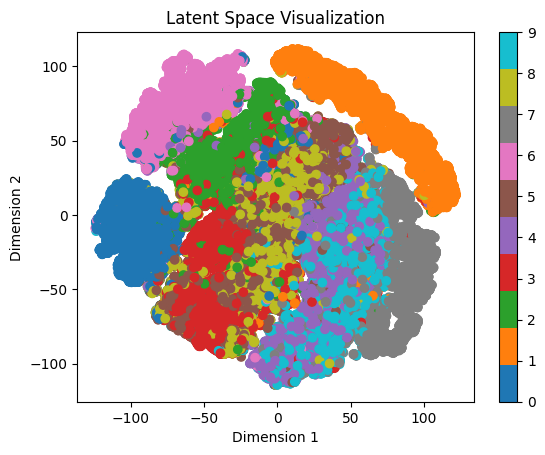

Applied TSNE to reduce dimensions to 2 for visualization


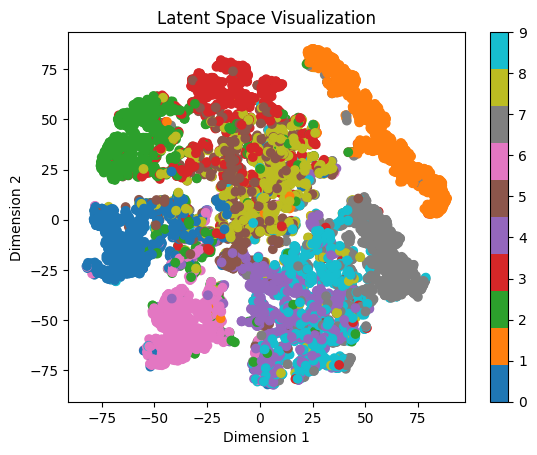

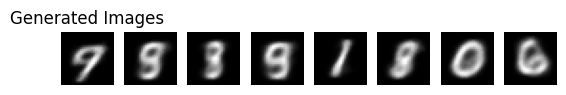

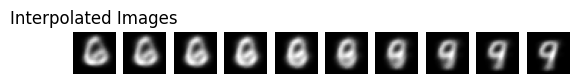

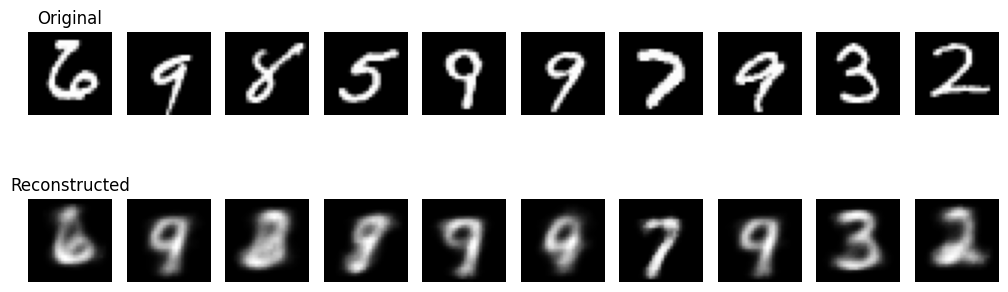

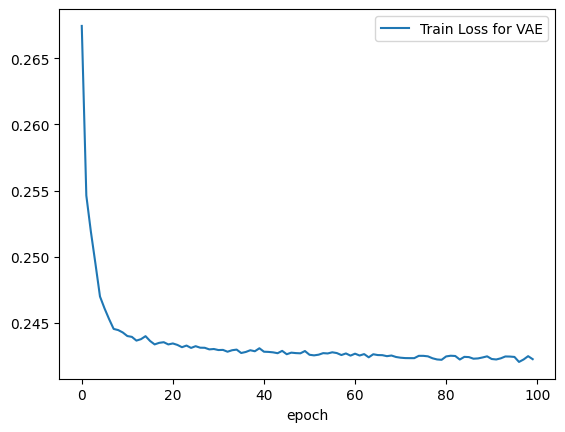

In [44]:
main_VAE()

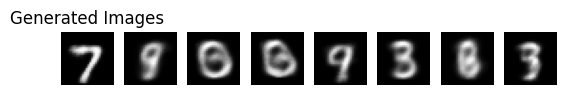

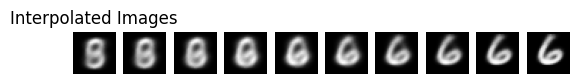

In [49]:
# @title Test VAE
def try_VAE(VAE_file):
    train_loader, test_loader = load_dataloaders()
    data, _ = next(iter(test_loader))
    img1, img2 = data[:2].to(Config.DEVICE)

    vae = VAE(Config.IMG_NUMELEMS, Config.HIDDEN_DIMS, Config.LATENT_DIM).to(Config.DEVICE)
    vae.load_state_dict(torch.load(VAE_file))

    samples = generate_samples(vae, num_samples=8)
    plot_imags(samples, title= 'Generated Images')

    intrps = interpolate_latent_space(vae, img1.view(28,28), img2.view(28,28), 10)
    plot_imags(intrps, title= 'Interpolated Images')

try_VAE('VAE.pt')